###### Instructions

- Follow the installation instructions in the readme file
- Answer the questions in this notebook
- Once your work is finished: restart the kernel, run all cells in order and check that the outputs are correct.
- Send your completed notebook to `remy.degenne@inria.fr` with email title `SL_TP1_NAME1_NAME2` (or `SL_TP1_NAME` if you work alone).

**Deadline: Friday, December 5, 11:59 CET**.

If you don't want to use a local installation, you can try Google Colab:

<a target="_blank" href="https://colab.research.google.com/github/RemyDegenne/remydegenne.github.io/blob/master/docs/SL_2025/StoreManagement.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
# This cell is setting up google colab. Ignore it if you work locally.
if 'google.colab' in str(get_ipython()):
  print("Installing packages, please wait a few moments. Restart the runtime after the installation.")
  # install rlberry library
  !pip install scipy rlberry

## Store Management MDP

You own a bike store. During week $t$, the (random) demand is $D_t$ units. 
On Monday morning you may choose to command $A_t$ additional units: they are delivered immediately before the shop opens. For each week:

  * Maintenance cost: $h$ per unit in stock left from the previous week (no maintenance is needed for newly commanded items)
  * Command cost: $c$ for each unit ordered + $c_0$ per command
  * Sales profit: $p$ per unit sold
  * Constraint: 
    - your warehouse has a maximal capacity of $M$ unit (any additionnal bike gets stolen)
    - you cannot sell bikes that you don't have in stock


* State: number of bikes in stock left from the last week => state space $\mathcal{S} = \{0,\dots, M\}$
* Action: number of bikes commanded at the beginning of the week => action space $\mathcal{A} = \{0, \dots ,M\}$ 
* Reward = balance of the week: if you command $a_t$ bikes,
$$r_t = -c_0 \mathbb{1}_{(a_t >0)}- c \times a_t - h\times s_t + p \times \min(D_t, s_t+a_t, M)$$
* Transitions: you end the week with the number of bikes $$s_{t+1} = \max\big(0, \min(M, s_t + a_t)  - D_t \big)$$ 

Our goal is to maximize the discounted sum of rewards, starting from an initial stock $s_1$, that is to find a policy whose value is 
$$V^*(s_1) = \max_{\pi}\mathbb{E}_{\pi}\left[\sum_{s=1}^{\infty} \gamma^{s-1}r_s \right].$$

In [2]:
import numpy as np
import random as rd
import gymnasium as gym
from matplotlib import pyplot as plt
import time 

### Problem parameters 

In [3]:
M = 15 # stock capacity
h = 0.3 # maintenance cost (per unit)
c = 0.5 # ordering cost (per unit)
c0 = 0.3 # fix delivery cost per command
p = 1 # selling price (per unit)

### Specifying the demand distribution 

As an example of demand distribution, we choose a (truncated) geometric distribution, for which 
$$\mathbb{P}(D_t = m) = q(1-q)^m \ \ \forall m \in \{0,\dots,M-1\}$$
and $\mathbb{P}(D_t = M) = 1 - \sum_{m=0}^{M-1}\mathbb{P}(D_t = m)$. We provide below a function that simulate the demand. 

In [4]:
# demand distribution (truncated geometric with parameter q)
q = 0.1
pdem = np.array([q*(1-q)**m for m in range(M+1)])
pdem[M] = pdem[M]+1-np.sum(pdem)

print("the average demand is ",np.sum([m*pdem[m] for m in range(M+1)]))

def SimuDemand(pdem): 
    cpdem = np.cumsum(pdem)
    i=0
    u = rd.random()
    while (u >cpdem[i]):
        i = i+1
    return i 

print("a simulated demand is ",SimuDemand(pdem))

the average demand is  7.1469798111481575
a simulated demand is  15


### Encoding the MDP as a gymnasium environment

This is just a  toy example on how to create a gymnasium environement. 

Note that our environement is an example of tabular MDP for which the transition probabilities $P(s'|s,a)$ and the mean rewards $r(s,a)$ can actually be computed in closed form. Therefore we provide the transitions $(P)$ and mean rewards $(r)$ as attributes of the class. 

In [5]:
def nextstate(s,a,d,M):
    # computes the next state if the demand is d
    return max(0,min(M,s+a) -d)

def nextreward(s,a,d,M,c,c0,h,p):
    # computes the reward if the demand is d
    rew = -c*a - h*s + p*min(M,d,s+a)
    if (a>0):
        rew = rew - c0
    return rew

class StoreManagement(gym.Env):
    """
    Retail Store Management environment
    The environment defines which actions can be taken at which point and
    when the agent receives which reward.
    """
    def __init__(self,FirstState,M=15,h=0.3,c=0.5,c0=0.3,p=1,q=0.1):
        
        # General variables defining the environment
        self.Stock_Capacity = M
        self.Maintenance_Cost = h
        self.Order_Cost = c 
        self.Delivery_Cost = c0
        self.Selling_Price = p
        pdem = np.array([q*(1-q)**m for m in range(M+1)])
        pdem[M] = pdem[M]+1-np.sum(pdem)
        self.Demand_Distribution = pdem
        
        # Define the action space
        self.action_space = gym.spaces.Discrete(self.Stock_Capacity+1)

        # Define the state space (state space = observation space in this example)
        self.observation_space = gym.spaces.Discrete(self.Stock_Capacity+1)

        # current time step
        self.curr_step = -1 # 
        
        # initial state
        self.state = FirstState

        # computation of the MDP parameters
        P = np.zeros((M+1,M+1,M+1)) # P[s,a,s'] = p(s' | s,a) 
        r = np.zeros((M+1,M+1)) # r[s,a] = average reward received in state s when playing action a
        ## iteration over all possible states, actions, and possible demand values
        for a in range(M+1):
            for s in range(M+1):
                for d in range(M+1):
                    # next state and reward with demand d
                    ns = max(0,min(M,s+a) -d)
                    reward = -c*a - h*s+p*min(M,d,s+a)
                    if (a>0):
                        reward = reward - c0
                    P[s,a,ns] += pdem[d]
                    r[s,a] += pdem[d] * reward
        self.P = P # P[s,a,ns] = P(ns | s,a)
        self.r = r # r[s,a] = r(s,a)

    def step(self, action):
        """
        simulates a transition following an action in the current state
        action : int
        """
        self.curr_step += 1
        # simulate the demand 
        Demand = SimuDemand(self.Demand_Distribution)
        # compute the reward
        reward = nextreward(self.state,action,Demand,self.Stock_Capacity,self.Order_Cost,self.Delivery_Cost,self.Maintenance_Cost,self.Selling_Price)
        # compute the next state 
        self.state = nextstate(self.state,action,Demand,self.Stock_Capacity)
        # return 4 elements: observation / reward / termination? / truncation ? / information  
        return self.state, reward, False, False,{}

    def reset(self,InitialStock):
        """
        Reset the state of the environment and returns an initial observation.
        """
        self.curr_step = -1
        self.state = InitialStock
    
    def _render(self, mode='human'):
        """optional visualization of the interaction: none here"""
        return


### A function that simulates a trajectory under a policy Pi starting from some state $s_0$

**Complete the function below to simulate a trajectory of length $T$ from an initial state $s_0$ under a policy Pi**

Write a function `SimulateTrajectory` that takes 3 arguments T, Pi and s0. It should initialize a StoreManagement environment in the state s0. Then, for T steps, will will:
- query the state of the environment
- choose an action according to the policy
- get a new state and a reward by calling `state, reward, _, _, _ = env.step(action)` (where `env` is the environment)

The function should return two arrays of length `T`: one for the states visited and one for the rewards obtained.

In [7]:
def SimulateTrajectory(T,Pi,s0):
    """return a vector of T successive states and a vector of T successive rewards"""
    Rewards = np.zeros(T)
    States = np.zeros(T)
    # Initialize the environment with the starting stock s0
    env=StoreManagement(s0)
    
    for t in range(T):
        # Query the current state of the environment
        current_state = env.state
        States[t] = current_state
        
        # Choose an action according to the policy. 
        # Note: The provided baseline policies (PiUniform, PiConstant, PiThreshold) 
        # return the *order quantity* 'a', which is the action.
        action = Pi(current_state)
        
        # Take a step in the environment
        # state, reward, terminated, truncated, info = env.step(action)
        # Note: env.step returns a 5-tuple, we only need state and reward
        new_state, reward, _, _, _ = env.step(action)
        
        # Store the reward obtained at this step
        Rewards[t] = reward
        
    return States, Rewards

### Running simulations with three simple baselines 

In [8]:
s1 = 10 # initial stock 
gamma = 0.97 # discount factor 

def PiUniform(s):
    # pick uniformly at random in {0,1,...,M-s}
    x = rd.sample(range(M+1-s),1)
    return s+x[0]

def PiConstant(s,c=3):
    # oder a constant number of c bikes 
    return min(c,M-s)

def PiThreshold(s,m1=4,m2=10):
    # if less than m1 bikes in stock, refill it up to m2
    action = 0
    if (s <=m1):
        action = (m2-s)
    return action

**Plot the cumulative discounted reward as a function of time for the three baselines.**

You should plot one trajectory for each policy, all on the same graph. Don't forget to add legends to the graph.

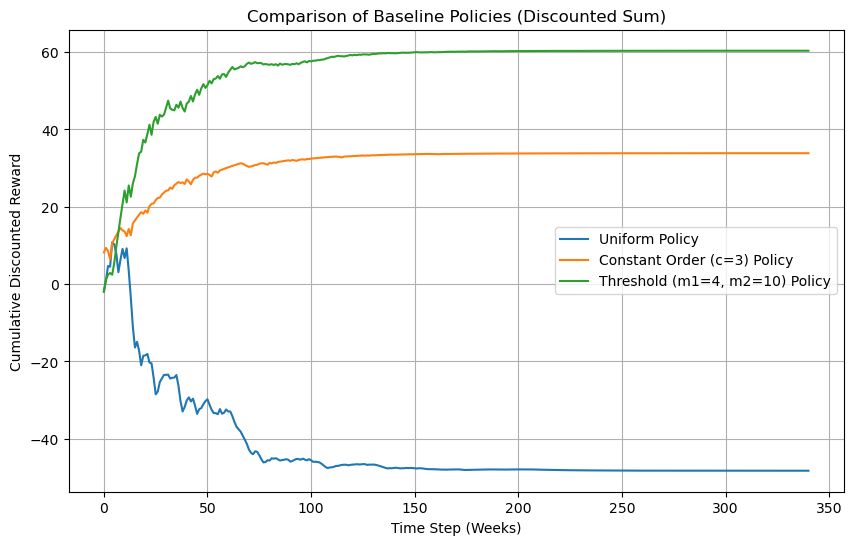

In [9]:
T = int(np.log(1/(0.001*(1-gamma)))/np.log(1/gamma)) # truncation of the infinite sum

s1 = 10 # initial stock 
gamma = 0.97 # discount factor 

# --- Simulate Trajectories ---
States1, Rewards1 = SimulateTrajectory(T, PiUniform, s1)
States2, Rewards2 = SimulateTrajectory(T, PiConstant, s1)
States3, Rewards3 = SimulateTrajectory(T, PiThreshold, s1)

# --- Compute Cumulative Discounted Reward ---
# Array of discounted factors: gamma^0, gamma^1, gamma^2, ...
discount_factors = np.power(gamma, np.arange(T)) 

# Compute the discounted reward at each step (r_t * gamma^(t-1))
DiscountedRewards1 = Rewards1 * discount_factors
DiscountedRewards2 = Rewards2 * discount_factors
DiscountedRewards3 = Rewards3 * discount_factors

# Compute the cumulative discounted reward (cumulative sum of the above)
CumulativeDiscountedRewards1 = np.cumsum(DiscountedRewards1)
CumulativeDiscountedRewards2 = np.cumsum(DiscountedRewards2)
CumulativeDiscountedRewards3 = np.cumsum(DiscountedRewards3)

# --- Plotting ---
plt.figure(figsize=(10, 6))
plt.plot(CumulativeDiscountedRewards1, label='Uniform Policy')
plt.plot(CumulativeDiscountedRewards2, label='Constant Order (c=3) Policy')
plt.plot(CumulativeDiscountedRewards3, label='Threshold (m1=4, m2=10) Policy')

plt.xlabel('Time Step (Weeks)')
plt.ylabel('Cumulative Discounted Reward')
plt.title('Comparison of Baseline Policies (Discounted Sum)')
plt.legend()
plt.grid(True)
plt.show()


### Evolution of the stock

Text(0.5, 1.0, 'Evolution of the stock under a threshold policy')

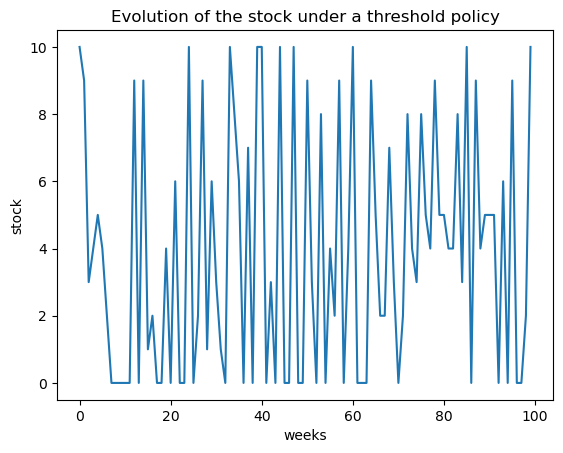

In [10]:
plt.figure()
plt.plot(States3[range(100)])
plt.xlabel('weeks')
plt.ylabel('stock')
plt.title('Evolution of the stock under a threshold policy')

# Dynamic Programming

So far, when doing simulations, we just interacted with the environements with calls to the "step" functions (which boils down to simulating the demand each week). However, we assume that all the parameters (including the demand distribution itself, paramterized by $q$) are known, we can evaluate policies, and compute the optimal policy using the knowledge of the MDP parameters (encoded in env.P and env.r).

In [14]:
env = StoreManagement(0,M=15,h=0.3,c=0.5,c0=0.3,p=1,q=0.1)

# MDP parameters
P = env.P # P[s,a,s'] = p(s' | s,a) 
r = env.r # r[s,a] = average reward received in state s when playing action a

## Evaluation of deterministic policies

**Evalute a policy of your choice using Monte-Carlo simulation, i.e. compute the value of this policy in all states.** 

In a Monte-Carlo simulation to estimate the value of $V^\pi(s)$, we collect `MC` values for the sum of discounted rewards over long enough trajectories starting at $s$, then compute the mean of these `MC` values.
We need to compute trajectories from *all* states.

Observe that we do *not* need the knowledge of $P$ and $r$ for this method, simulating trajectories is enough.

In [15]:
## Computes the values in each state by Monte-Carlo simulation
Policy = PiThreshold # Using the Threshold policy

MC = 100 # number of Monte-Carlo simulations
# Re-calculate T, the horizon for the discounted sum
T = int(np.log(1/(0.001*(1-gamma)))/np.log(1/gamma)) 

Values = np.zeros(M+1)

for s0 in range(M + 1): # Iterate over all possible starting states
    mc_rewards = np.zeros(MC)
    for i in range(MC):
        # Simulate a trajectory
        States, Rewards = SimulateTrajectory(T, Policy, s0)
        
        # Calculate the discounted return G_0 = sum_{t=0}^{T-1} gamma^t * r_t
        discount_factors = np.power(gamma, np.arange(T)) 
        discounted_return = np.sum(Rewards * discount_factors)
        mc_rewards[i] = discounted_return
    
    # Estimate V^pi(s0) as the average of the Monte-Carlo returns
    Values[s0] = np.mean(mc_rewards)

print("the estimated value in each states for the threshold policy are:")
print(Values)

the estimated value in each states for the threshold policy are:
[46.16545216 48.83016854 49.69523954 49.54353545 50.9077558  48.49995818
 51.14302645 49.76564456 50.29253864 52.71950466 50.54121475 54.55945637
 50.71704281 51.65805325 50.49053778 52.41189321]


**Implement a function that evaluates a deterministic policy Pi using the matrix inversion technique. Compare the output with the previous method for the same policy.**

Unlike the previous evaluation method, this one requires the knowledge of $P$ and $r$. 

In [16]:
def EvaluatePolicy(Pi):
    # input: function (could also be vector as we can only use this method for deterministic policies)
    # Get the number of states
    S = M + 1
    
    # 1. Build the vector of expected immediate rewards r^pi
    r_pi = np.zeros(S)
    # 2. Build the transition probability matrix P^pi
    P_pi = np.zeros((S, S))
    
    for s in range(S):
        # Determine the action a taken by policy Pi in state s
        # Note: Since Pi is a function, we call it. It returns the order quantity (action).
        a = Pi(s) 
        
        # Handle the case where the policy might return a float (e.g., in Python 3.x), cast to int
        a = int(a)
        
        # r^pi(s) = r(s, a)
        r_pi[s] = r[s, a] 
        
        # P^pi(s, s') = P(s' | s, a)
        P_pi[s, :] = P[s, a, :]
        
    # 3. Solve the system (I - gamma * P^pi) * V^pi = r^pi
    
    # I - gamma * P^pi
    matrix_A = np.eye(S) - gamma * P_pi
    
    # V^pi = inv(A) * r_pi
    # Use np.linalg.solve for better numerical stability than np.linalg.inv
    Values = np.linalg.solve(matrix_A, r_pi)
    
    return Values

# Example usage and comparison
Policy = PiThreshold
Values_Matrix = EvaluatePolicy(Policy)

print("Values estimated by Matrix Inversion for the Threshold Policy:")
print(Values_Matrix)
print("\nComparing with Monte-Carlo values (first method):")
print(Values) # Print the Monte-Carlo values computed in the previous cell

Values estimated by Matrix Inversion for the Threshold Policy:
[48.73499347 48.93499347 49.13499347 49.33499347 49.53499347 49.71122352
 50.04440882 50.34326461 50.60790492 50.83844345 51.03499347 51.19766791
 51.32657931 51.42183984 51.48356131 51.51185512]

Comparing with Monte-Carlo values (first method):
[46.16545216 48.83016854 49.69523954 49.54353545 50.9077558  48.49995818
 51.14302645 49.76564456 50.29253864 52.71950466 50.54121475 54.55945637
 50.71704281 51.65805325 50.49053778 52.41189321]


**Evaluate two different policies and visualize their values for the different states in order to decide which one is better.** 

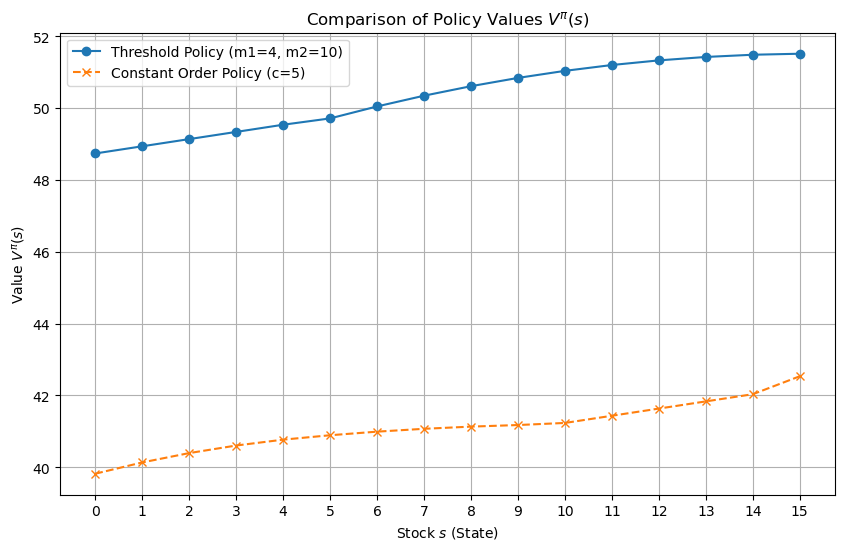

In [17]:
# --- Define a second policy for comparison ---
def PiConstant_mod(s, c=5):
    # Same as PiConstant but with c=5 for differentiation
    return min(c, M - s)

# --- Evaluate the policies ---
# Policy 1: Threshold Policy (m1=4, m2=10)
Policy1_Values = EvaluatePolicy(PiThreshold)
# Policy 2: Constant Order Policy (c=5)
Policy2_Values = EvaluatePolicy(PiConstant_mod)

# --- Visualization ---
plt.figure(figsize=(10, 6))
plt.plot(range(M + 1), Policy1_Values, marker='o', label='Threshold Policy (m1=4, m2=10)')
plt.plot(range(M + 1), Policy2_Values, marker='x', linestyle='--', label='Constant Order Policy (c=5)')

plt.xlabel('Stock $s$ (State)')
plt.ylabel('Value $V^{\\pi}(s)$')
plt.title('Comparison of Policy Values $V^{\\pi}(s)$')
plt.legend()
plt.grid(True)
plt.xticks(range(M + 1))
plt.show()

# Interpretation
# The policy with the higher value for a given state is generally better. 
# The graph clearly shows which policy performs better across the state space.

## Computing the Optimal Policy: Policy Iteration 

The function given below performs policy improvement, and may be useful to implement both value iteration and policy iteration. Note that the (deterministic) policy it outputs is encoded as a vector, not a function. 


In [18]:
# policy improvement
def Improve(V):
    '''computes the Q table associated to V and 
    return Pi=greedy(V)=greedy(Q) as well as max_{a} Q[s,a]'''
    Pi = np.zeros(M+1) # improved policy 
    newV = np.zeros(M+1)
    # compute the Q table 
    Q = np.zeros((M+1,M+1))
    for s in range(M+1):
        for a in range(M+1):
            Q[s,a]=r[s,a]+gamma*np.sum([P[s,a,ns]*V[ns] for ns in range(M+1)])
        # improvement (greedy policy wrt to Q)
        pi = np.argmax(Q[s,:])
        Pi[s]=pi
        newV[s]=Q[s,pi]
        Pi=Pi.astype(int)
    return Pi,newV


V = np.random.randint(M+1,size=M+1) 
newPi,newV = Improve(V)
print("improved policy from random:",newPi)

improved policy from random: [11 10  9  8  7  6  5  4  3  2  1  0  0  2  0  0]


**Implement Value Iteration and Policy Iteration.**

First, check that the two algorithms output the same optimal policy. Then, you may compare the number of iteration needed by both algorithms as well as the executation time. 

In [19]:
def ValueIteration(epsilon=1e-3): # epsilon = guaranteed precision
    S = M + 1
    # 1. Initialization: Arbitrary initial value function
    V = np.zeros(S) 
    
    nIt = 0
    while True:
        nIt += 1
        
        # --- Value Update (Bellman Optimality Operator) ---
        # The Improve function computes Q-values and returns Pi=greedy(V) and newV=max_a Q[s,a].
        # The newV is exactly the result of applying the Bellman Optimality Operator T* on V.
        Pi_ignored, newV = Improve(V) 
        
        # --- Check for Convergence ---
        # Convergence is guaranteed when max |newV(s) - V(s)| < epsilon * (1-gamma) / (2*gamma)
        # A simpler check for the difference between successive value functions:
        max_diff = np.max(np.abs(newV - V))
        
        V = newV
        
        if max_diff < epsilon * (1 - gamma) / (2 * gamma):
            break
            
    # 3. Policy Extraction (Final Improvement step to get the optimal policy Pi*)
    Pi, V = Improve(V) 
    
    return Pi, V, nIt

In [20]:
def PolicyIteration():
    S = M + 1
    # 1. Initialization: Start with a random initial policy (e.g., order 0)
    Pi = np.zeros(S, dtype=int)
    
    nIt = 0
    policy_stable = False
    
    while not policy_stable:
        nIt += 1
        
        # --- Policy Evaluation (Exact: Matrix Inversion) ---
        # Need a function representation of Pi to pass to EvaluatePolicy
        def current_Pi_func(s):
            return Pi[s]
            
        V = EvaluatePolicy(current_Pi_func)
        
        # --- Policy Improvement (Greedy Update) ---
        newPi, newV_ignored = Improve(V) 
        
        # --- Check for Stability ---
        if np.array_equal(newPi, Pi):
            policy_stable = True
        
        Pi = newPi
        
    return Pi, V, nIt

In [22]:
start = time.time()
Pi,V,nIt = ValueIteration()
elapsed_VI = time.time()-start

start = time.time()
Pi2,V2,nIt2 = PolicyIteration()
elapsed_PI = time.time()-start

# Check if policies are the same
policies_match = "Yes, policies match." if np.array_equal(Pi, Pi2) else "No, policies differ."

print(f"Policies Match: {policies_match}\n")

print(f"Value Iteration:")
print(f"  Policy: {Pi}")
print(f"  Value: {V}")
print(f"  Iterations: {nIt}")
print(f"  Time: {elapsed_VI:.6f} seconds\n")

print(f"Policy Iteration:")
print(f"  Policy: {Pi2}")
print(f"  Value: {V2}")
print(f"  Iterations: {nIt2}")
print(f"  Time: {elapsed_PI:.6f} seconds")

# Store V for the next plot
Vstar=np.copy(V)

Policies Match: Yes, policies match.

Value Iteration:
  Policy: [9 8 7 6 5 4 0 0 0 0 0 0 0 0 0 0]
  Value: [48.8681983  49.0681983  49.2681983  49.4681983  49.6681983  49.8681983
 50.17547036 50.47388913 50.73809389 50.9681983  51.16431565 51.32655886
 51.45504046 51.54987262 51.61116714 51.63903542]
  Iterations: 378
  Time: 0.498058 seconds

Policy Iteration:
  Policy: [9 8 7 6 5 4 0 0 0 0 0 0 0 0 0 0]
  Value: [48.86867719 49.06867719 49.26867719 49.46867719 49.66867719 49.86867719
 50.17594925 50.47436803 50.73857278 50.96867719 51.16479455 51.32703775
 51.45551935 51.55035152 51.61164603 51.63951432]
  Iterations: 4
  Time: 0.005581 seconds


Here is a visualization of the optimal policy. 

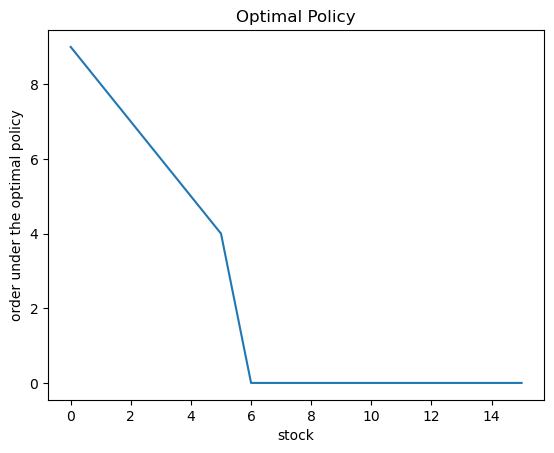

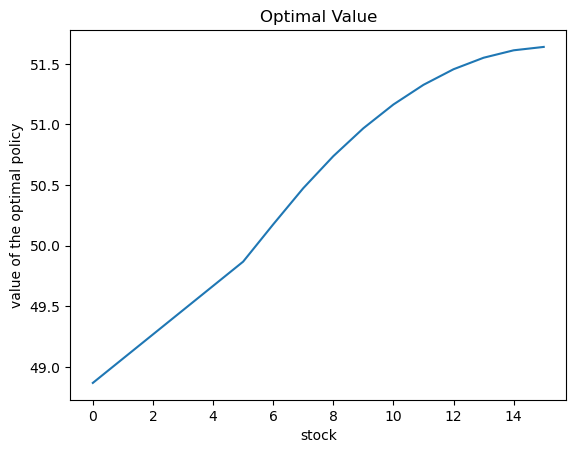

In [23]:
plt.plot(Pi2)
plt.xlabel('stock')
plt.ylabel('order under the optimal policy')
plt.title("Optimal Policy")

plt.figure()
plt.plot(V2)
plt.xlabel('stock')
plt.ylabel('value of the optimal policy')
plt.title("Optimal Value")

Vstar=np.copy(V)

**Plot the number of iterations needed for value iteration as a function of the precision parameter $\varepsilon$**

Try powers of 10: $\varepsilon=1$

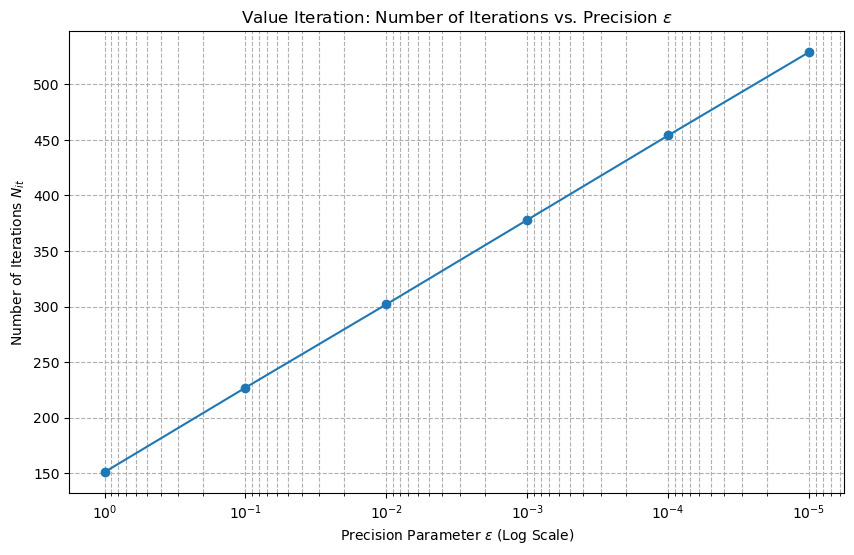

In [24]:
# Values of epsilon to test (powers of 10)
epsilon_powers = np.arange(-5, 1) # from 10^-5 to 10^0
epsilons = np.power(10.0, epsilon_powers)

iterations = []

# Run Value Iteration for each epsilon
for epsilon in epsilons:
    # ValueIteration already includes epsilon in its signature
    Pi_ignored, V_ignored, nIt = ValueIteration(epsilon=epsilon)
    iterations.append(nIt)

# Plotting the results
plt.figure(figsize=(10, 6))
# Use log scale for the x-axis (epsilon) since we are using powers of 10
plt.semilogx(epsilons, iterations, marker='o', linestyle='-') 

plt.xlabel('Precision Parameter $\\varepsilon$ (Log Scale)')
plt.ylabel('Number of Iterations $N_{it}$')
plt.title('Value Iteration: Number of Iterations vs. Precision $\\varepsilon$')
plt.grid(True, which="both", ls="--")
plt.gca().invert_xaxis() # Show higher precision (smaller epsilon) to the right
plt.show()